<a href="https://colab.research.google.com/github/ThienNguyen3001/Stock-Price-Prediction-LSTM-RNN/blob/main/stock_price_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import thư viện

In [1]:
%%capture
!git clone https://github.com/ThienNguyen3001/Stock-Price-Prediction-LSTM-RNN.git
!pip3 install d2l

In [2]:
import os
if not os.getcwd().endswith('Stock-Price-Prediction-LSTM-RNN'):
    %cd Stock-Price-Prediction-LSTM-RNN

/content/Stock-Price-Prediction-LSTM-RNN


In [3]:
!pwd

/content/Stock-Price-Prediction-LSTM-RNN


In [4]:
import pandas as pd
import numpy as np
from numpy import zeros, newaxis

import torch
import torch.nn as nn
torch.manual_seed(38)
from d2l import torch as d2l

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams


# Thêm data

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("suruchiarora/yahoo-finance-dataset-2018-2023")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/suruchiarora/yahoo-finance-dataset-2018-2023/versions/1


In [6]:
df = pd.read_excel(r'/root/.cache/kagglehub/datasets/suruchiarora/yahoo-finance-dataset-2018-2023/versions/1/yahoo_data.xlsx')
df

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Apr 28, 2023",33797.43,34104.56,33728.40,34098.16,34098.16,354310000
1,"Apr 27, 2023",33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2,"Apr 26, 2023",33596.34,33645.83,33235.85,33301.87,33301.87,321170000
3,"Apr 25, 2023",33828.34,33875.49,33525.39,33530.83,33530.83,297880000
4,"Apr 24, 2023",33805.04,33891.15,33726.09,33875.40,33875.40,252020000
...,...,...,...,...,...,...,...
1253,"May 07, 2018",24317.66,24479.45,24263.42,24357.32,24357.32,307670000
1254,"May 04, 2018",23865.22,24333.35,23778.87,24262.51,24262.51,329480000
1255,"May 03, 2018",23836.23,23996.15,23531.31,23930.15,23930.15,389240000
1256,"May 02, 2018",24097.63,24185.52,23886.30,23924.98,23924.98,385350000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1258 non-null   object 
 1   Open         1258 non-null   float64
 2   High         1258 non-null   float64
 3   Low          1258 non-null   float64
 4   Close*       1258 non-null   float64
 5   Adj Close**  1258 non-null   float64
 6   Volume       1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [8]:
df.describe()

,Open,High,Low,Close*,Adj Close**,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,29595.823045,29776.945739,29402.432226,29599.361677,29599.361677,3.450636e+08
std,4006.078299,4009.007573,4004.949066,4007.468822,4007.468822,1.069142e+08
min,19028.360000,19121.010000,18213.650000,18591.930000,18591.930000,8.615000e+07
25%,26041.267500,26163.155000,25877.872500,26027.120000,26027.120000,2.773125e+08
50%,29201.410000,29335.685000,28996.500000,29199.460000,29199.460000,3.247250e+08
75%,33604.027500,33825.445000,33346.827500,33600.342500,33600.342500,3.875100e+08
max,36722.600000,36952.650000,36636.000000,36799.650000,36799.650000,9.159900e+08


# Làm sạch dữ liệu

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
df.set_index('Date', inplace = True)

In [11]:
df.rename(columns={'Close*': 'Close', 'Adj Close**': 'Adj Close'}, inplace=True)

# Trực quan hóa dữ liệu

## Time series

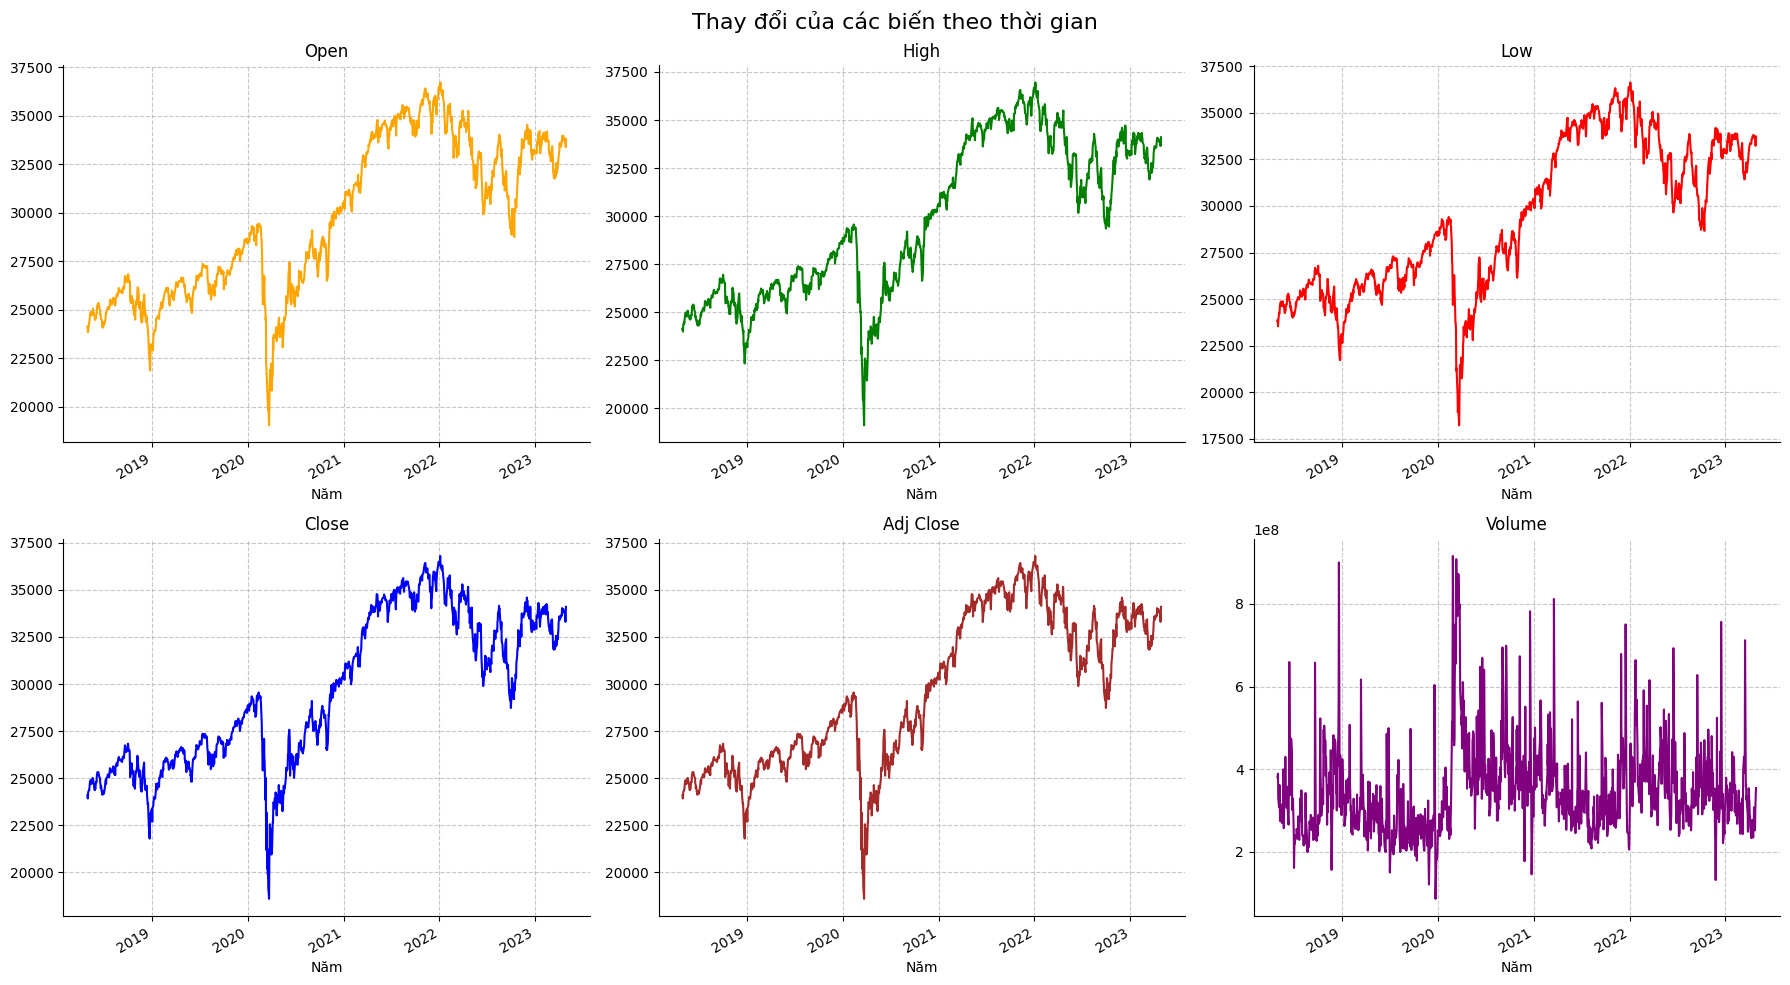

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Thay đổi của các biến theo thời gian', fontsize=16)

metrics = {
    (0,0): ('Open', 'orange', 'Open'),
    (0,1): ('High', 'green', 'High'),
    (0,2): ('Low', 'red', 'Low'),
    (1,0): ('Close', 'blue', 'Close'),
    (1,1): ('Adj Close', 'brown', 'Adj Close'),
    (1,2): ('Volume', 'purple', 'Volume')
}

for (row, col), (metric, color, title) in metrics.items():
    df[metric].plot(ax=axes[row,col], color=color)
    axes[row,col].set_title(title)
    axes[row,col].spines[['top', 'right']].set_visible(False)
    axes[row,col].grid(True, linestyle='--', alpha=0.7)
    axes[row,col].set_xlabel('Năm')

plt.tight_layout()
plt.show()

* Tất cả các biểu đồ ngoại trừ "Volume" đều có một dạng tương tự và đó là bởi vì sau giá mở cửa, thị trường chứng khoán thường có một biến động nhỏ lên xuống khiến cho các biểu đồ giá này tuân theo cùng một mô hình nhưng đối với cột "Volume" thì đây là một quá trình khá ngẫu nhiên đối với lượng giao dịch trong một ngày nhất định.

## Box plot

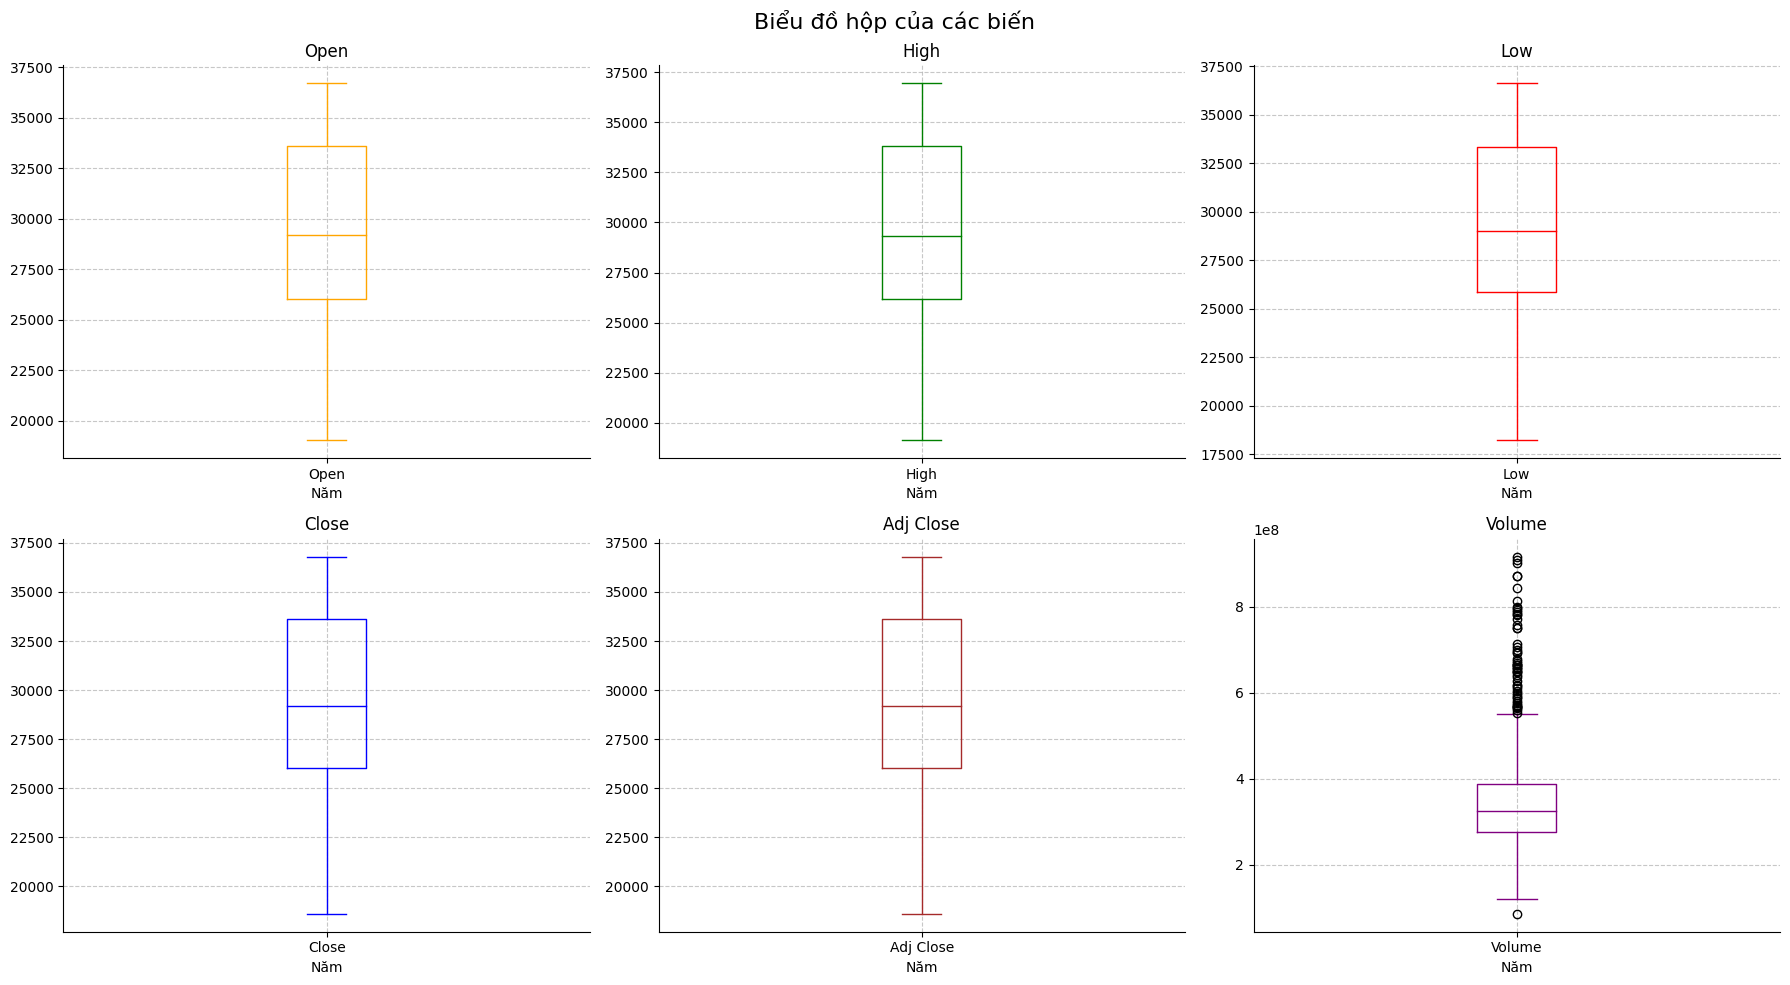

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Biểu đồ hộp của các biến', fontsize=16)

metrics = {
    (0,0): ('Open', 'orange', 'Open'),
    (0,1): ('High', 'green', 'High'),
    (0,2): ('Low', 'red', 'Low'),
    (1,0): ('Close', 'blue', 'Close'),
    (1,1): ('Adj Close', 'brown', 'Adj Close'),
    (1,2): ('Volume', 'purple', 'Volume')
}

for (row, col), (metric, color, title) in metrics.items():
    df[metric].plot.box(ax=axes[row,col], color=color)
    axes[row,col].set_title(title)
    axes[row,col].spines[['top', 'right']].set_visible(False)
    axes[row,col].grid(True, linestyle='--', alpha=0.7)
    axes[row,col].set_xlabel('Năm')

plt.tight_layout()
plt.show()

* Đối với các biến về giá, có thể nhận thấy rằng nhìn chung chúng được phân bổ tốt nhưng biến "Volume" chứa một số giá trị ngoại lệ. Điều này được giải thích bởi thực tế là khi cổ phiếu giao dịch bắt đầu tăng thì giá trị giá giảm xuống, giải thích cho sự sụt giảm đột ngột về giá và "Volume" đạt đỉnh.

## Tỷ lệ tăng trưởng

* Tỷ lệ tăng trưởng là phần trăm thay đổi của một giá trị trong một khoảng thời gian cụ thể. Công thức tính là:
$
\text{Growth Rate} = \frac{\text{New Value} - \text{Old Value}}{\text{Old Value}} \times 100\%
$

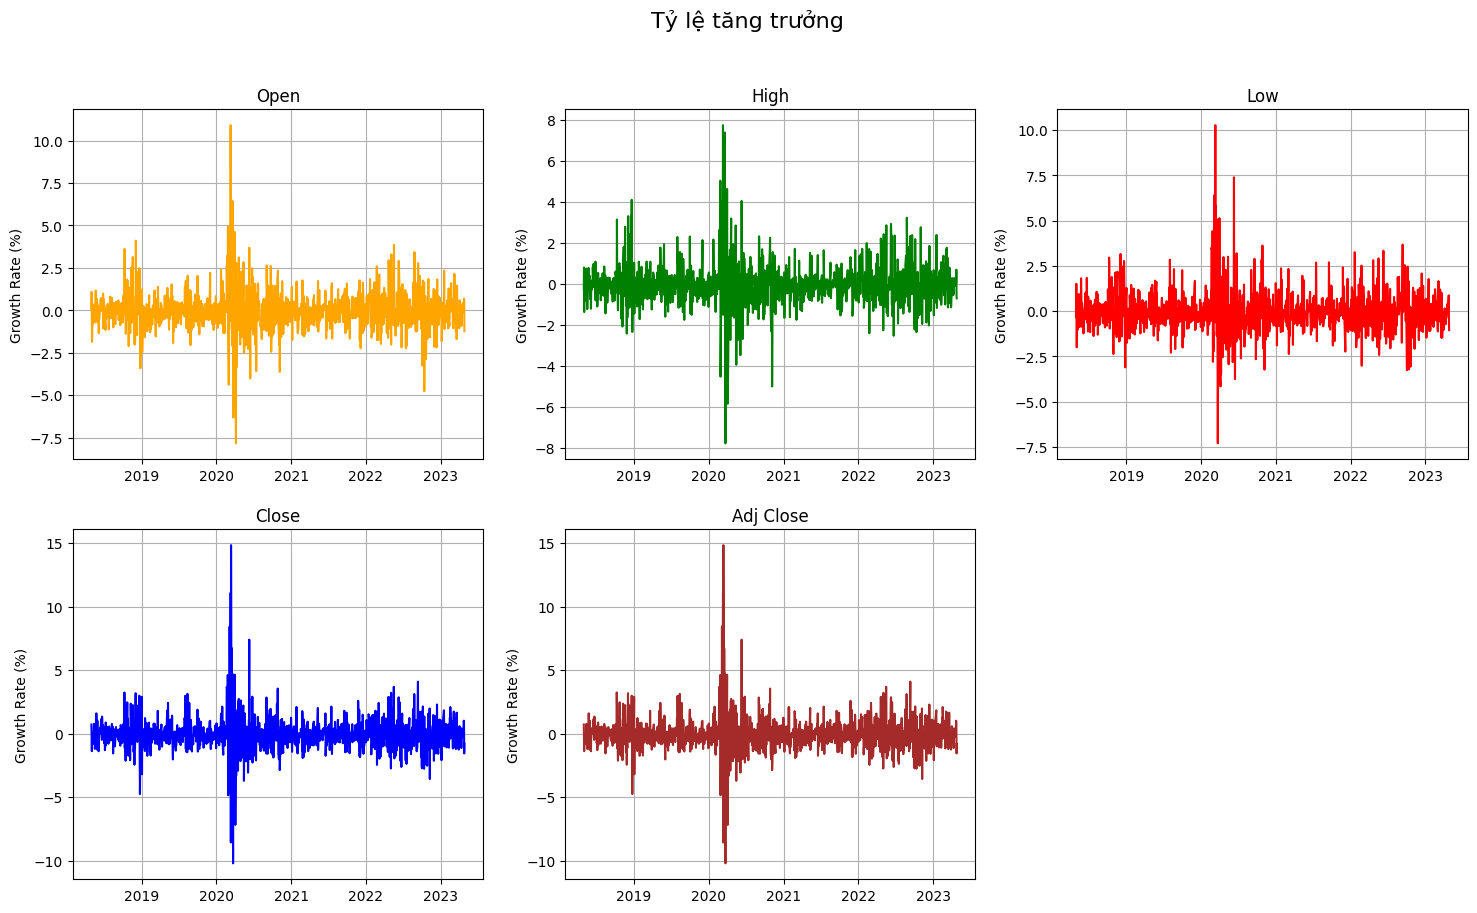

In [14]:
plt.figure(figsize=(18,10))
plt.suptitle("Tỷ lệ tăng trưởng", fontsize=16)
i=1
colors = ['orange', 'green', 'red', 'blue', 'brown', 'purple']
for x, color in zip(df.columns[:-1], colors):
    plt.subplot(2,3,i)
    df['Growth Rate'] = (df[x] - df[x].shift(1)) / df[x].shift(1) * 100
    plt.plot(df.index, df['Growth Rate'], linestyle='-', color=color)
    plt.xlabel(None)
    plt.ylabel('Growth Rate (%)')
    plt.title(f'{x}')
    plt.grid(True)
    i+=1
plt.show()

* Ở các biến giá thì tỷ lệ tăng trưởng biến động khá cao ở khoảng độ giữa năm 2020 và 2021, đỉnh điểm của dịch Covid-19

## Ma trận tương quan

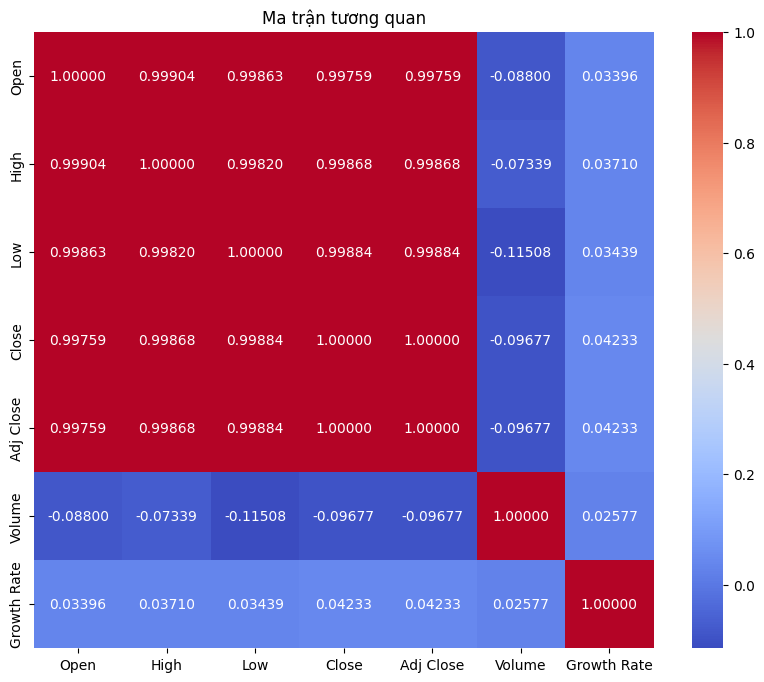

In [15]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".5f")
plt.title('Ma trận tương quan')
plt.show()

* Ma trận này thể hiện mối liên hệ rất tuyến tính mạnh giữa các giá trị về giá (High, Low, Open, Close, Adj Close).
* "Volume" có mối tương quan âm với các biến giá, nghĩa là khi "Volume" tăng, các giá trị về giá có xu hướng giảm nhẹ, nhưng mối quan hệ này không quá mạnh.

# Chuẩn bị dữ liệu

In [16]:
closing_price = df[['Close']]

window_size = 15 #14 input values and 15th value is the target

In [17]:
from src.split_data import split_data
#Preparing inputs
scaler,X_train, y_train, X_test, y_test, train_size, test_size = split_data(closing_price, window_size)

In [18]:
#Converting data to tensors for the model
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train_rnn = y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

# Chạy mô hình RNN

In [19]:
from src.rnn import RNN

In [20]:
#Model specifics
num_input, num_hidden, num_layer, num_output = 1, 4, 1, 1
rnn_model = RNN(num_input, num_hidden, num_layer, num_output)

In [21]:
#Loss and optimiser functions
num_epochs, lr = 101, 0.1
rnn_criterion = nn.MSELoss(reduction = 'mean')
rnn_updater = torch.optim.Adam(rnn_model.parameters(), lr = lr)

In [22]:
#Training RNN model
train_hist_rnn = np.zeros(num_epochs)

for epoch in range(num_epochs):
    y_train_pred_rnn = rnn_model(X_train)

    loss = rnn_criterion(y_train_pred_rnn, y_train_rnn)
    train_hist_rnn[epoch] = loss.item()
    if epoch % 5 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    rnn_updater.zero_grad()
    loss.backward()
    rnn_updater.step()

Epoch  0 MSE:  0.23227770626544952
Epoch  5 MSE:  0.0703229084610939
Epoch  10 MSE:  0.021587377414107323
Epoch  15 MSE:  0.01926971971988678
Epoch  20 MSE:  0.013203704729676247
Epoch  25 MSE:  0.0075042350217700005
Epoch  30 MSE:  0.006314117461442947
Epoch  35 MSE:  0.003824522253125906
Epoch  40 MSE:  0.0035724835470318794
Epoch  45 MSE:  0.0030492376536130905
Epoch  50 MSE:  0.0028645936399698257
Epoch  55 MSE:  0.002731321845203638
Epoch  60 MSE:  0.0025632299948483706
Epoch  65 MSE:  0.0024856398813426495
Epoch  70 MSE:  0.002394813345745206
Epoch  75 MSE:  0.0023230004590004683
Epoch  80 MSE:  0.0022812061943113804
Epoch  85 MSE:  0.002245417097583413
Epoch  90 MSE:  0.002211058745160699
Epoch  95 MSE:  0.0021754454355686903
Epoch  100 MSE:  0.0021376293152570724


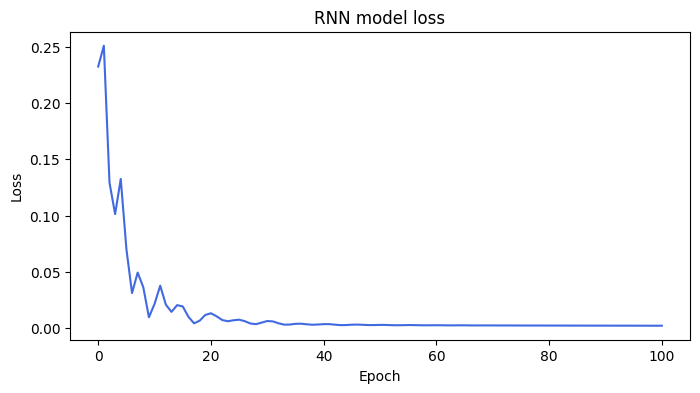

In [23]:
#Training loss for RNN model
rcParams['figure.figsize'] = 8,4
rnn_loss_fig = sns.lineplot(data = train_hist_rnn, color = 'royalblue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RNN model loss")
plt.show(rnn_loss_fig);

# Chạy mô hình LSTM

In [24]:
from src.lstm import LSTM

In [25]:
#Model specifics
num_input, num_hidden, num_layer, num_output = 1, 4, 1, 1
lstm_model = LSTM(num_input, num_hidden, num_layer, num_output)

In [26]:
#Loss and optimiser functions
num_epochs, lr = 101, 0.1
lstm_criterion = nn.MSELoss(reduction = 'mean')
lstm_updater = torch.optim.Adam(lstm_model.parameters(), lr = lr)

In [27]:
#Training LSTM model
train_hist_lstm = np.zeros(num_epochs+1)

for epoch in range(num_epochs):
    y_train_pred_lstm = lstm_model(X_train)

    loss = lstm_criterion(y_train_pred_lstm, y_train_lstm)
    train_hist_lstm[epoch] = loss.item()
    if epoch % 5 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    lstm_updater.zero_grad()
    loss.backward()
    lstm_updater.step()

Epoch  0 MSE:  0.65696781873703
Epoch  5 MSE:  0.1805809587240219
Epoch  10 MSE:  0.14341555535793304
Epoch  15 MSE:  0.09852270036935806
Epoch  20 MSE:  0.07038863003253937
Epoch  25 MSE:  0.020467812195420265
Epoch  30 MSE:  0.017989519983530045
Epoch  35 MSE:  0.017949635162949562
Epoch  40 MSE:  0.011863070540130138
Epoch  45 MSE:  0.00780799426138401
Epoch  50 MSE:  0.006534857675433159
Epoch  55 MSE:  0.005582825280725956
Epoch  60 MSE:  0.004876299295574427
Epoch  65 MSE:  0.004448161460459232
Epoch  70 MSE:  0.004021449014544487
Epoch  75 MSE:  0.0036104118917137384
Epoch  80 MSE:  0.0033123758621513844
Epoch  85 MSE:  0.0030808469746261835
Epoch  90 MSE:  0.0028757185209542513
Epoch  95 MSE:  0.0027107978239655495
Epoch  100 MSE:  0.0025801188312470913


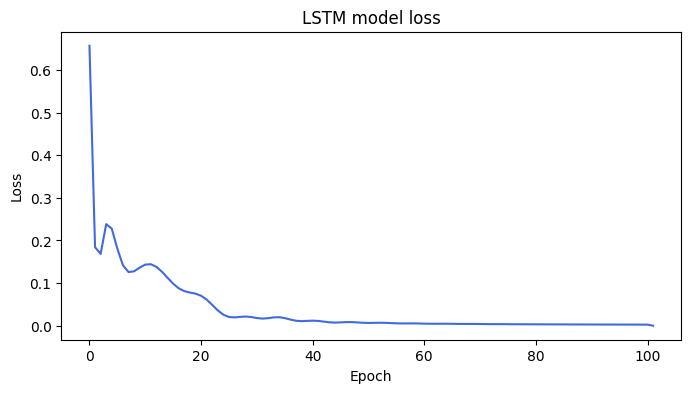

In [28]:
#Training loss for LSTM model
rcParams['figure.figsize'] = 8,4
lstm_loss_fig = sns.lineplot(data = train_hist_lstm, color = 'royalblue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM model loss")
plt.show(lstm_loss_fig);

# Test hiệu năng

## RNN

In [29]:
#RNN model performance on testing data
y_test_pred_rnn = rnn_model(X_test)

In [30]:
#Converting the data back to its original form
rnn_train_pred = scaler.inverse_transform(y_train_pred_rnn.detach().numpy())
rnn_train_orig = scaler.inverse_transform(y_train_rnn.detach().numpy())
rnn_test_pred = scaler.inverse_transform(y_test_pred_rnn.detach().numpy())
rnn_test_orig = scaler.inverse_transform(y_test_rnn.detach().numpy())

In [31]:
from src.calculate_metrics import calculate_metrics
train_rnn_rmse, train_rnn_mse, train_rnn_mae, train_rnn_mape, train_rnn_r2 = calculate_metrics(rnn_train_orig[:, 0], rnn_train_pred[:, 0])

# Calculate metrics for testing data
test_rnn_rmse, test_rnn_mse, test_rnn_mae, test_rnn_mape, test_rnn_r2 = calculate_metrics(rnn_test_orig[:, 0], rnn_test_pred[:, 0])

# Print the metrics
print('Train:')
print(f'RMSE: {train_rnn_rmse:.2f}')
print(f'MSE: {train_rnn_mse:.2f}')
print(f'MAE: {train_rnn_mae:.2f}')
print(f'MAPE: {train_rnn_mape:.2f}')
print(f'R2: {train_rnn_r2:.2f}')

print('\nTest:')
print(f'RMSE: {test_rnn_rmse:.2f}')
print(f'MSE: {test_rnn_mse:.2f}')
print(f'MAE: {test_rnn_mae:.2f}')
print(f'MAPE: {test_rnn_mape:.2f}')
print(f'R2: {test_rnn_r2:.2f}')

Train:
RMSE: 148.77
MSE: 22131.28
MAE: 104.73
MAPE: 0.00
R2: 0.99

Test:
RMSE: 418.71
MSE: 175320.45
MAE: 326.81
MAPE: 0.01
R2: 0.91


In [32]:
#Preparing predictions for the plot comparisons for RNN model
rnn_train_data = np.append(rnn_train_orig, rnn_train_pred, axis = 1)
rnn_test_data = np.append(rnn_test_orig, rnn_test_pred, axis = 1)

rnn_train_plot = pd.DataFrame(rnn_train_data)
rnn_train_plot.columns = ['Actual', 'Prediction']
rnn_test_plot = pd.DataFrame(rnn_test_data)
rnn_test_plot.columns = ['Actual', ' Prediction']

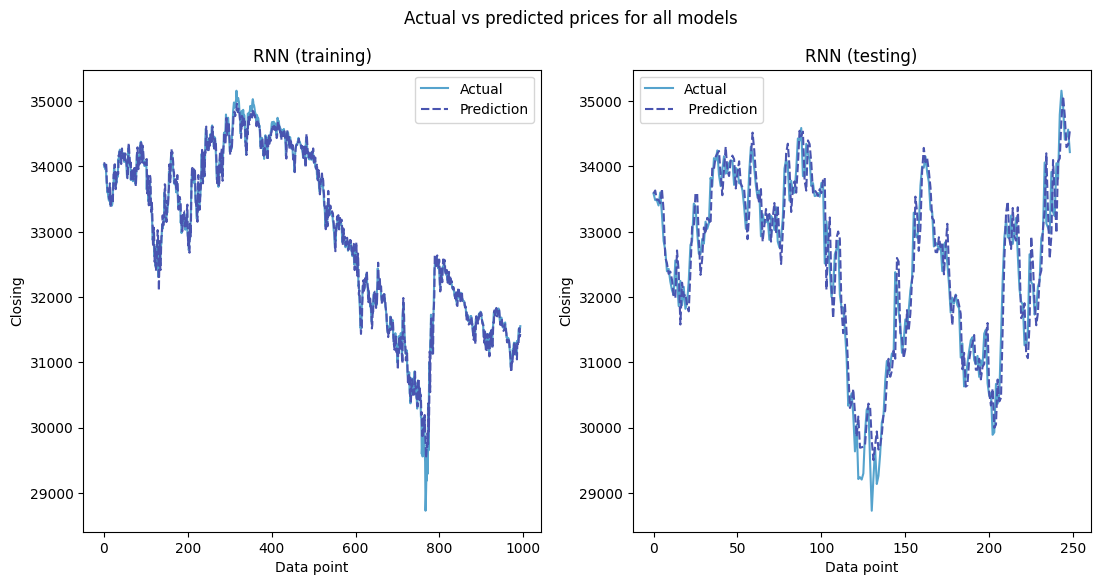

In [33]:
#Predictions vs actual price for the RNN model
sns.set_palette('icefire')

fig, axes = plt.subplots(1, 2, sharex = False, figsize = (13,6))
fig.suptitle('Actual vs predicted prices for all models')

rnn_training_plot = sns.lineplot(ax = axes[0], data = rnn_train_plot)
rnn_training_plot.set_title('RNN (training)')
rnn_training_plot.set_xlabel('Data point')
rnn_training_plot.set_ylabel('Closing')

rnn_testing_plot = sns.lineplot(ax = axes[1], data = rnn_test_plot)
rnn_testing_plot.set_title('RNN (testing)')
rnn_testing_plot.set_xlabel('Data point')
rnn_testing_plot.set_ylabel('Closing');

## LSTM

In [34]:
#LSTM model performance on testing data
y_test_pred_lstm = lstm_model(X_test)

In [35]:
#Converting the data back to its original form
lstm_train_pred = scaler.inverse_transform(y_train_pred_lstm.detach().numpy())
lstm_train_orig = scaler.inverse_transform(y_train_lstm.detach().numpy())
lstm_test_pred = scaler.inverse_transform(y_test_pred_lstm.detach().numpy())
lstm_test_orig = scaler.inverse_transform(y_test_lstm.detach().numpy())

In [36]:
from src.calculate_metrics import calculate_metrics
train_lstm_rmse, train_lstm_mse, train_lstm_mae, train_lstm_mape, train_lstm_r2 = calculate_metrics(lstm_train_orig[:, 0], lstm_train_pred[:, 0])

# Calculate metrics for testing data
test_lstm_rmse, test_lstm_mse, test_lstm_mae, test_lstm_mape, test_lstm_r2 = calculate_metrics(lstm_test_orig[:, 0], lstm_test_pred[:, 0])

# Print the metrics
print('Train:')
print(f'RMSE: {train_lstm_rmse:.2f}')
print(f'MSE: {train_lstm_mse:.2f}')
print(f'MAE: {train_lstm_mae:.2f}')
print(f'MAPE: {train_lstm_mape:.2f}')
print(f'R2: {train_lstm_r2:.2f}')

print('\nTest:')
print(f'RMSE: {test_lstm_rmse:.2f}')
print(f'MSE: {test_lstm_mse:.2f}')
print(f'MAE: {test_lstm_mae:.2f}')
print(f'MAPE: {test_lstm_mape:.2f}')
print(f'R2: {test_lstm_r2:.2f}')

Train:
RMSE: 163.44
MSE: 26712.49
MAE: 104.29
MAPE: 0.00
R2: 0.98

Test:
RMSE: 438.80
MSE: 192549.44
MAE: 325.01
MAPE: 0.01
R2: 0.90


In [37]:
#Preparing predictions for the plot comparisons
lstm_train_data = np.append(lstm_train_orig, lstm_train_pred, axis = 1)
lstm_test_data = np.append(lstm_test_orig, lstm_test_pred, axis = 1)

lstm_train_plot = pd.DataFrame(lstm_train_data)
lstm_train_plot.columns = ['Actual', 'Prediction']
lstm_test_plot = pd.DataFrame(lstm_test_data)
lstm_test_plot.columns = ['Actual', ' Prediction']

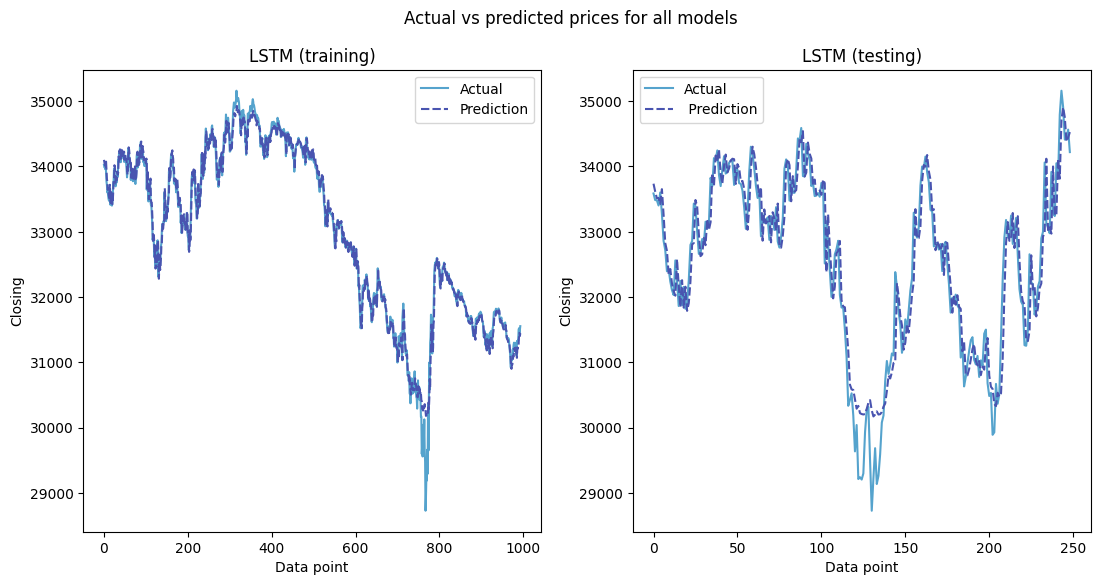

In [38]:
#Prediction vs actual price for LSTM model
sns.set_palette('icefire')

fig, axes = plt.subplots(1, 2, sharex = False, figsize = (13,6))
fig.suptitle('Actual vs predicted prices for all models')

lstm_training_plot = sns.lineplot(ax = axes[0], data = lstm_train_plot)
lstm_training_plot.set_title('LSTM (training)')
lstm_training_plot.set_xlabel('Data point')
lstm_training_plot.set_ylabel('Closing')

lstm_testing_plot = sns.lineplot(ax = axes[1], data = lstm_test_plot)
lstm_testing_plot.set_title('LSTM (testing)')
lstm_testing_plot.set_xlabel('Data point')
lstm_testing_plot.set_ylabel('Closing');


## Tổng hợp



| **Model** | **Dataset** | **RMSE** | **MSE**     | **MAE** | **MAPE** | **R²** |
|-----------|-------------|----------|-------------|---------|----------|--------|
| **RNN**   | Train       | 148.77   | 22,131.28   | 104.73  | 0.00     | 0.99   |
|           | Test        | 418.71   | 175,320.45  | 326.81  | 0.01     | 0.91   |
| **LSTM**  | Train       | 163.44   | 26,712.49   | 104.29  | 0.00     | 0.98   |
|           | Test        | 438.80   | 192,549.44  | 325.01  | 0.01     | 0.90   |


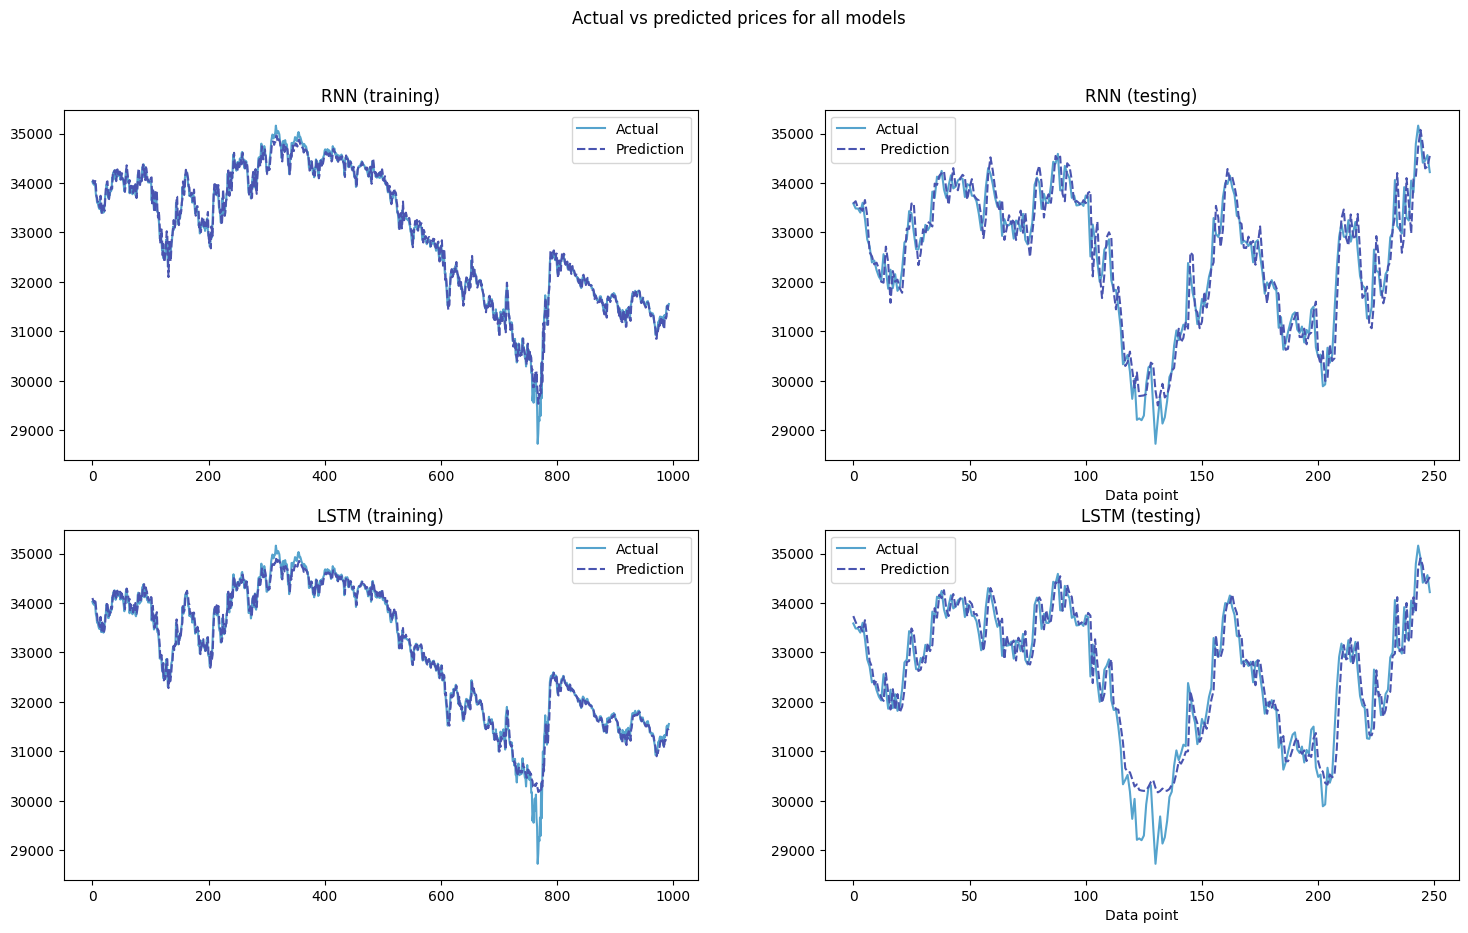

In [42]:
fig, axes = plt.subplots(2, 2, sharex = False, sharey =  False, figsize = (18,10))
fig.suptitle('Actual vs predicted prices for all models')

rnn_training_plot = sns.lineplot(ax = axes[0][0], data = rnn_train_plot)
rnn_training_plot.set_title('RNN (training)')

rnn_testing_plot = sns.lineplot(ax = axes[0][1], data = rnn_test_plot)
rnn_testing_plot.set_title('RNN (testing)')
rnn_testing_plot.set_xlabel('Data point')

lstm_training_plot = sns.lineplot(ax = axes[1][0], data = lstm_train_plot)
lstm_training_plot.set_title('LSTM (training)')

lstm_testing_plot = sns.lineplot(ax = axes[1][1], data = lstm_test_plot)
lstm_testing_plot.set_title('LSTM (testing)')
lstm_testing_plot.set_xlabel('Data point');